# Homework 1


### About
This script specifically requests monthly page view counts for specific articles from a CSV file, which are subsequently parsed and stored in separate json files. Subsequently, we generate graphs as part of our data analysis process.

- This script leverages the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API) to retrieve page view data. 
- For more in-depth information and reference, you can consult the API documentation, specifically the [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data) section.

## 1. Pre Processing

In [114]:
# Imports
import numpy as np
import pandas as pd
import json, time, urllib.parse
import requests
import matplotlib.pyplot as plt

I have downloaded the data from the class Google drive, and it automatically converted to an Excel format. This file contains a list of all the articles that we plan to analyse.

In [115]:
# Read ARTICLE_TITLES from the XLSX file
xlsx_filename = 'thank_the_academy.AUG.2023.csv.xlsx'

# Load the XLSX file into a DataFrame
df = pd.read_excel(xlsx_filename)

\* **The following two code snippet below were developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the Creative Commons CC-BY license. Revision 1.2 - August 14, 2023. Some of the original code made be modified, however it still falls under the Creative Commons license.**

In [117]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# header for the request, with the email. Change this to use yours, so that Wiki could contact you in case of any issues.
REQUEST_HEADERS = {
    'User-Agent': 'aadi2000@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       "2015010100",   # start date
    "end":         "2023093000"    # end date
}

The below is a function that takes in the article title and the access level to send a GET request to the API. The result from the API is returned back as the output of the function.

In [118]:
# function to send a request, and receive the JSON response

def request_pageviews_per_article(article_title = None, 
                                  access = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")
        
    #test for access parameter
    if access:
        request_template['access'] = access

    if not request_template['access']:
        raise Exception("Must supply an access to make a pageviews request.")

        
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

As we aim to store the data in json, it would be ideal to create dictonaries to store the data from the requests, and then write it as JSON.

In [120]:
# dictionaries to store data
all_monthly_mobile_access = {}
all_monthly_desktop_access = {}
all_monthly_cumulative = {}

Now, we would have to send reqeusts for each article / row in the dataframe df. Here are the steps involved
- We iterate through each row in the dataframe
    - In each row, we get the article name
    - We make 3 calls for the article, to obtain the data for the 3 different views
    - For the mobile views, we add up the mobile-app and mobile-web values
    - If we actually receive data with out error, then
        - For mobile data, we parse the mobile app and mobile web view jsons, and add up the views to create a new json. We just collect the timestamp and the views from the output to store, as the other information is redundant.
        - For the desktop data, we just parse and create our json files.
        - For the cumulataive one, we add up the views from the mobile and desktop jsons to create a new one
    - Else, we just print the name and that we were unable to call it.
- The output is stored the 3 respective json files




In [121]:
for index, row in df.iterrows():
    article_name = row['name']
    print(index)
    
    # Mobile-app access request
    mobile_app_views = request_pageviews_per_article(article_name, 
                                                     access="mobile-app")
    # Mobile-web access request
    mobile_web_views = request_pageviews_per_article(article_name, 
                                                     access="mobile-web")

    # Desktop access request
    desktop_views = request_pageviews_per_article(article_name, 
                                                  access="desktop")
    
    if mobile_web_views.get('items') is not None:
        
        # Cleaning the web access data to just get the timestamp
        mobile_web_data = mobile_web_views['items']
        monthly_mobile_web_access = {}
        for item in mobile_web_data:
            month = item['timestamp'][:6]  
            pageviews = item['views']
            monthly_mobile_web_access[month] = pageviews

       # Cleaning the app access data to just get the timestamp
        mobile_app_data = mobile_app_views['items']
        monthly_mobile_app_access = {}
        for item in mobile_app_data:
            month = item['timestamp'][:6] 
            pageviews = item['views']
            monthly_mobile_app_access[month] = pageviews

        # Combining both the datasets for the mobile access json file
        monthly_mobile_access = {}
        for month in monthly_mobile_web_access.keys():
            web_count = monthly_mobile_web_access.get(month, 0)
            app_count = monthly_mobile_app_access.get(month, 0)
            total_mobile_count = web_count + app_count
            monthly_mobile_access[month] = total_mobile_count

        # Cleaning the desktop data to just get the timestamp
        desktop_data = desktop_views['items']
        monthly_desktop_access = {}
        for item in desktop_data:
            month = item['timestamp'][:6] 
            pageviews = item['views']
            monthly_desktop_access[month] = pageviews

        # Creating the Json files
        all_monthly_mobile_access[article_name] = monthly_mobile_access
        all_monthly_desktop_access[article_name] = monthly_desktop_access
        
        
        # Creating the cumulative dataset by adding the mobile and the desktop datasets.
        monthly_cumulative = {}
        for month in monthly_mobile_access.keys():
            total_mobile = monthly_mobile_access.get(month, 0)
            total_desktop = monthly_desktop_access.get(month, 0)
            total_cumulative = total_mobile + total_desktop
            monthly_cumulative[month] = total_cumulative

        all_monthly_cumulative[article_name] = monthly_cumulative
    else:
        print(article_name,' - Unable to collect information for this.')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [183]:
# Save all data to JSON files
with open("academy_monthly_mobile_201507-202309.json", "w") as mobile_file:
    json.dump(all_monthly_mobile_access, mobile_file)

with open("academy_monthly_desktop_201507-202309.json", "w") as desktop_file:
    json.dump(all_monthly_desktop_access, desktop_file)

with open("academy_monthly_cumulative_201507-202309.json", "w") as cumulative_file:
    json.dump(all_monthly_cumulative, cumulative_file)

## 2. Analysis

It is easier to deal with pandas dataframe in python, and thus, both the mobile and desktop json files are converted into pandas dataframes for manipulation and analysis

In [170]:
#  mobile and desktop data into a DataFrame
df_mobile = pd.DataFrame(all_monthly_mobile_access)
df_desktop = pd.DataFrame(all_monthly_desktop_access)

### Question 1

The approach here is as follows

- find the mean for every column (i.e, for every article)
- find the column/article with the highest and lowest page views
- just plot those columns

In [171]:
# Calculate the average pageviews for each article

average_mobile = df_mobile.mean()
average_desktop = df_desktop.mean()

# Find articles with the highest and lowest average pageviews
max_mobile_article = average_mobile.idxmax()
min_mobile_article = average_mobile.idxmin()
max_desktop_article = average_desktop.idxmax()
min_desktop_article = average_desktop.idxmin()

In [172]:
# Sort the DataFrames by the index (assuming the index is a datetime)
df_mobile.sort_index(inplace=True)
df_desktop.sort_index(inplace=True)

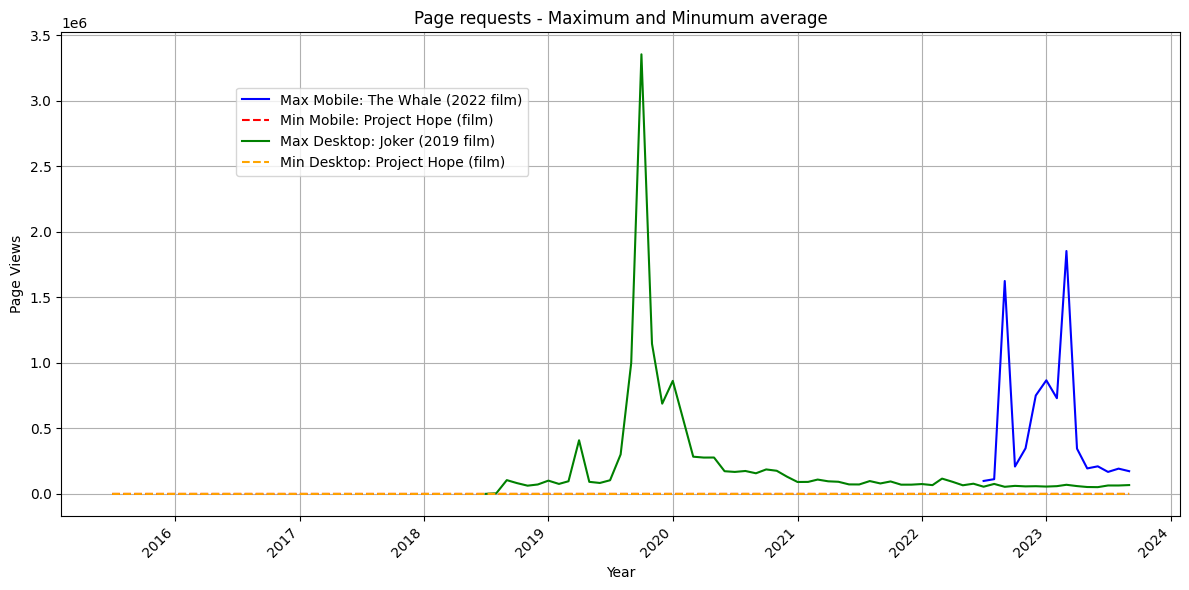

In [175]:
# Create a figure for the plot
plt.figure(figsize=(12, 6))

# Set the title and labels
plt.title("Page requests - Maximum and Minumum average")
plt.xlabel("Year")

# Convert the timestamp strings to datetime objects
df_mobile.index = pd.to_datetime(df_mobile.index, format='%Y%m')
df_desktop.index = pd.to_datetime(df_desktop.index, format='%Y%m')

# Plot data for mobile views
plt.plot(df_mobile.index, df_mobile[max_mobile_article], label=f'Max Mobile: {max_mobile_article}', color='blue')
plt.plot(df_mobile.index, df_mobile[min_mobile_article], label=f'Min Mobile: {min_mobile_article}', linestyle='--', color='red')

# Plot data for desktop views
plt.plot(df_desktop.index, df_desktop[max_desktop_article], label=f'Max Desktop: {max_desktop_article}', color='green')
plt.plot(df_desktop.index, df_desktop[min_desktop_article], label=f'Min Desktop: {min_desktop_article}', linestyle='--', color='orange')

plt.ylabel("Page Views")
plt.xticks(rotation=45, ha="right")  # Rotate labels

plt.grid(True)
plt.legend(loc="upper left", bbox_to_anchor=(0.15, 0.9))
plt.tight_layout()

#Save the plot to an image file
plt.savefig("Max-Min-Avg.png")

### Question 2

The approach here is as follows

- Find the top 10 articles in both the dataframes.
- Plot those columns

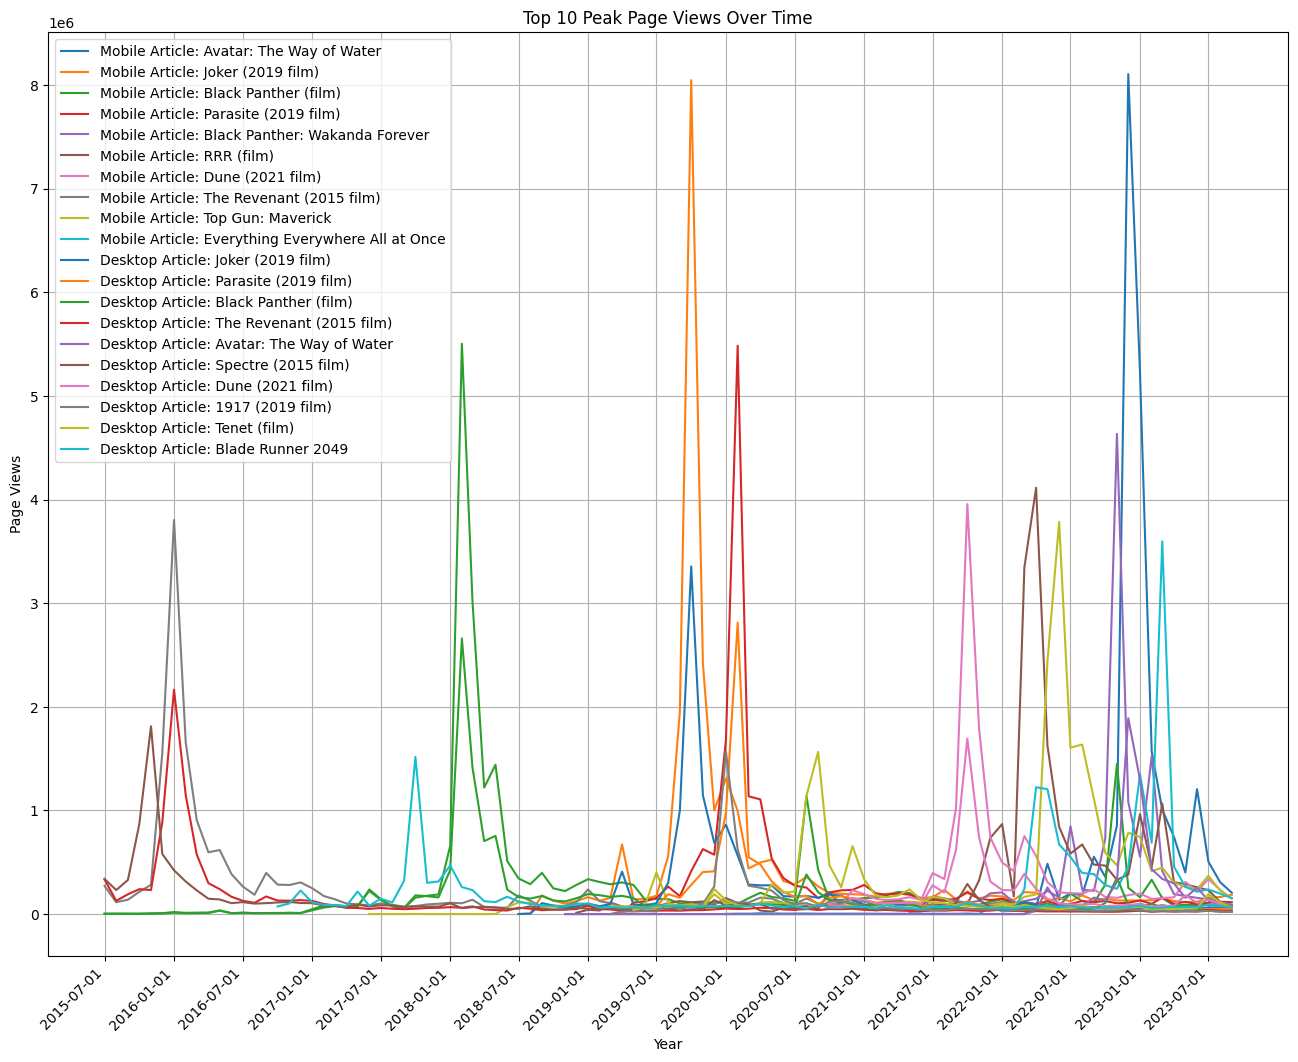

In [176]:
# Calculate the top 10 peak pageviews for each access type
top_10_mobile_articles = df_mobile.max().nlargest(10)
top_10_desktop_articles = df_desktop.max().nlargest(10)

# Create a figure for the plot
plt.figure(figsize=(16,12))

# Plot the top 10 peak pageviews for mobile
for article in top_10_mobile_articles.index:
    plt.plot(df_mobile.index, df_mobile[article], label=f"Mobile Article: {article}")

# Plot the top 10 peak pageviews for desktop
for article in top_10_desktop_articles.index:
    plt.plot(df_desktop.index, df_desktop[article], label=f"Desktop Article: {article}")

plt.xlabel("Year")
plt.ylabel("Page Views")
plt.title("Top 10 Peak Page Views Over Time")
plt.legend()
plt.xticks(df_mobile.index[::6], rotation=45, ha="right")
plt.grid(True)

# Save the plot to an image file
plt.savefig("PeakPageViews.png")

### Question 3

The approach here is as follows

- Find the smallest 10 articles by views in both the dataframes using nsmallest()
- Plot those columns

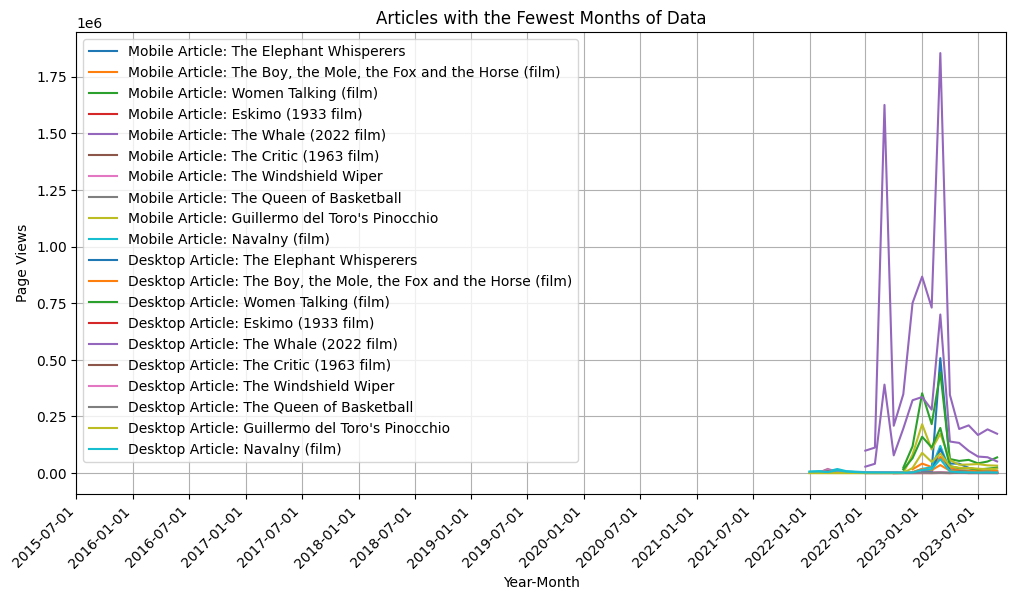

In [182]:
# Calculate articles with the fewest months of data
fewest_months_mobile_articles = df_mobile.count().nsmallest(10)
fewest_months_desktop_articles = df_desktop.count().nsmallest(10)

# Create a figure for the plot
plt.figure(figsize=(12, 6))

# Plot articles with the fewest months of data for mobile
for article in fewest_months_mobile_articles.index:
    plt.plot(df_mobile.index, df_mobile[article], label=f"Mobile Article: {article}")

# Plot articles with the fewest months of data for desktop
for article in fewest_months_desktop_articles.index:
    plt.plot(df_desktop.index, df_desktop[article], label=f"Desktop Article: {article}")

plt.xlabel("Year-Month")
plt.ylabel("Page Views")
plt.title("Articles with the Fewest Months of Data")
plt.legend()
plt.xticks(df_mobile.index[::6], rotation=45, ha="right")
plt.grid(True)

# Save the plot to an image file
plt.savefig("FewestMonths.png")


### NOTE: License


This code has some parts from the example that was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 14, 2023.